# Market Basket Analysis (FP-Growth)

This notebook demonstrates an end-to-end market basket analysis pipeline:
- Data cleaning
- Basket matrix creation
- FP-Growth frequent itemsets
- Association rules (support/confidence/lift)
- Visualizations


## Setup
```bash
python3 -m venv .venv
source .venv/bin/activate
python -m pip install -r requirements.txt
```


In [4]:
# Notebook setp
%pip install -r ../requirements.txt
%pip install -e ../

from market_basket.config import PrepConfig, MiningConfig
from market_basket.data_prep import load_dataset, clean_transactions, make_basket_matrix
from market_basket.mining import mine_itemsets_fp_growth, mine_rules
from market_basket.viz import (
    plot_support_confidence_bubble,
    plot_top_rules_by_lift,
    plot_rules_network_single_item
)


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Obtaining file:///Users/maanyachaturvedi/Downloads/market_basket_fp_growth
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for market-basket-fpgrowth (pyproject.toml) ... done
  Created wheel for market-basket-fpgrowth: filename=market_basket_fpgrowth-0.1.0-0.editable-py3-none-any.whl size=1431 sha256=b113bace74f1943ddb1f1993ebcce96f57ad37aa6906d330451c1d4e0bbbb5ef
  Stored in directory: /private/var/folders/jp/8hxtzh3j7fv2zk_fdqwdd4zr0000gn/T/pip-ephem-wheel-cache-66iijojb/wheels/f1/1e/9b/fd73935d4c8f8e8721ec2f3ed60cbcc8f3e248df4dd30c3c6b
Successfully built market-basket-fpgrowth
  Attempting uninstall: market-basket-fpgrowth
    Found 

## Parameters

In [5]:
DATA_FILE = "Online Retail.xlsx"
COUNTRY = None # set to "United Kingdom" to filter
TOP_K = 300

MIN_SUPPORT = 0.01
MIN_CONF = 0.3
MIN_LIFT = 1.2

## Load data


In [7]:
from pathlib import Path

project_root = Path("..").resolve()
data_path = project_root / "data" / DATA_FILE

df_raw = load_dataset(str(data_path))
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Clean + build basket matrix


In [8]:
prep_cfg = PrepConfig(
    country_filter=COUNTRY,  
    top_k_items=TOP_K        
)

df = clean_transactions(df_raw, prep_cfg)
basket = make_basket_matrix(df, prep_cfg)

print("Clean rows:", len(df))
print("Basket shape:", basket.shape)
basket.iloc[:5, :8]

Clean rows: 200157
Basket shape: (17990, 300)


Description,3 STRIPEY MICE FELTCRAFT,4 TRADITIONAL SPINNING TOPS,6 RIBBONS RUSTIC CHARM,60 CAKE CASES DOLLY GIRL DESIGN,60 CAKE CASES VINTAGE CHRISTMAS,60 TEATIME FAIRY CAKE CASES,72 SWEETHEART FAIRY CAKE CASES,ALARM CLOCK BAKELIKE CHOCOLATE
InvoiceNo,,,,,,,,
536365,False,False,False,False,False,False,False,False
536366,False,False,False,False,False,False,False,False
536367,False,False,False,False,False,False,False,False
536368,False,False,False,False,False,False,False,False
536370,False,False,False,False,False,False,False,False


## EDA (basket stats + top items)

Transactions: 17990
Unique items: 300
Avg basket size: 10.894163424124514
Median basket size: 7.0
Max basket size: 238


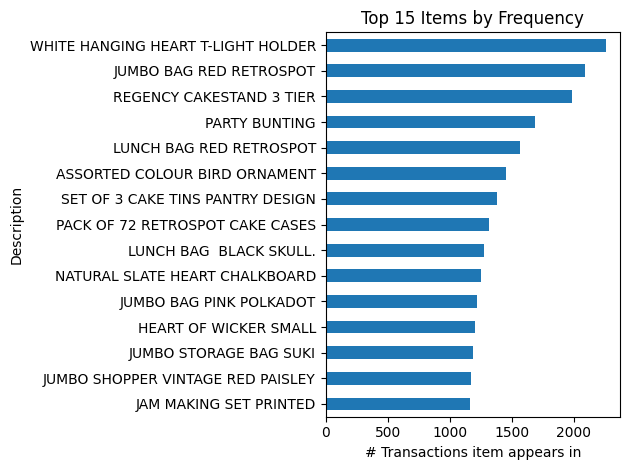

In [9]:
tx_sizes = basket.sum(axis=1)  # number of items per transaction

print("Transactions:", basket.shape[0])          # number of invoices
print("Unique items:", basket.shape[1])          # number of products
print("Avg basket size:", float(tx_sizes.mean()))
print("Median basket size:", float(tx_sizes.median()))
print("Max basket size:", int(tx_sizes.max()))

# Top 15 most frequently purchased items (by # of transactions they appear in)
top_items = basket.sum(axis=0).sort_values(ascending=False).head(15)
top_items

import matplotlib.pyplot as plt

plt.figure()
top_items.sort_values().plot(kind="barh")
plt.xlabel("# Transactions item appears in")
plt.title("Top 15 Items by Frequency")
plt.tight_layout()
plt.show()

## Mine frequent itemsets with FP-Growth
Start with `min_support=0.02` (2%) and lower gradually if you get too few itemsets.


In [10]:
mining_cfg = MiningConfig(min_support=0.01, min_confidence=0.3, min_lift=1.2)

itemsets = mine_itemsets_fp_growth(basket, mining_cfg)
print("Frequent itemsets:", len(itemsets))
itemsets.head(10)


Frequent itemsets: 1835


,support,itemsets,length
0,0.125625,(WHITE HANGING HEART T-LIGHT HOLDER),1
1,0.116287,(JUMBO BAG RED RETROSPOT),1
2,0.110561,(REGENCY CAKESTAND 3 TIER),1
3,0.093719,(PARTY BUNTING),1
4,0.086937,(LUNCH BAG RED RETROSPOT),1
5,0.080878,(ASSORTED COLOUR BIRD ORNAMENT),1
6,0.076987,(SET OF 3 CAKE TINS PANTRY DESIGN),1
7,0.073374,(PACK OF 72 RETROSPOT CAKE CASES),1
8,0.070762,(LUNCH BAG BLACK SKULL.),1
9,0.069427,(NATURAL SLATE HEART CHALKBOARD),1


## Generate and filter association rules
Filter rules using confidence and lift. Raise thresholds for fewer, stronger rules.


In [11]:
rules = mine_rules(itemsets, mining_cfg)
print("Filtered rules:", len(rules))
rules[["antecedents_str","consequents_str","support","confidence","lift"]].head(15)

Filtered rules: 2482


,antecedents_str,consequents_str,support,confidence,lift
0,"SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED ...",SET/6 RED SPOTTY PAPER PLATES,0.014730,0.895270,30.561503
1,SET/6 RED SPOTTY PAPER PLATES,"SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED ...",0.014730,0.502846,30.561503
2,POPPY'S PLAYHOUSE BEDROOM,POPPY'S PLAYHOUSE KITCHEN,0.017399,0.739953,30.531535
3,POPPY'S PLAYHOUSE KITCHEN,POPPY'S PLAYHOUSE BEDROOM,0.017399,0.717890,30.531535
4,"SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED ...",SET/6 RED SPOTTY PAPER CUPS,0.014730,0.716216,30.104509
5,SET/6 RED SPOTTY PAPER CUPS,"SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED ...",0.014730,0.619159,30.104509
6,"DOTCOM POSTAGE, SKULL SHOULDER BAG",SUKI SHOULDER BAG,0.010617,0.868182,29.469039
7,SUKI SHOULDER BAG,"DOTCOM POSTAGE, SKULL SHOULDER BAG",0.010617,0.360377,29.469039
8,"CHARLOTTE BAG SUKI DESIGN, RED RETROSPOT CHARL...","CHARLOTTE BAG PINK POLKADOT, STRAWBERRY CHARLO...",0.011340,0.607143,28.819261
9,"CHARLOTTE BAG PINK POLKADOT, STRAWBERRY CHARLO...","CHARLOTTE BAG SUKI DESIGN, RED RETROSPOT CHARL...",0.011340,0.538259,28.819261


## Insights

Below are the strongest association rules found after filtering by confidence and lift. Association rules indicate co-occurrence (not causation).

-**Partyware bundle**: Customers who purchase ET/20 RED RETROSPOT PAPER NAPKINS + SET/6 RED SPOTTY PAPER CUPS very frequently also buy SET/6 RED SPOTTY PAPER PLATES (confidence = .90, lift = 30.56). This is a clear indicator for a bundle/"complete the set" opportunity for these items.

-**Toy line cross-sell**: POPPY’S PLAYHOUSE BEDROOM → POPPY’S PLAYHOUSE KITCHEN shows a strong two-way relationship (confidence ≈ .72-.74, lift ≈ 30.53), suggesting customers tend to buy multiple products from this product line. Recommend items as "Frequently bought together" for the POPPY’S PLAYHOUSE series.

-**Set completion**: NAPKINS + PLATES → CUPS is also strong (confidence = 0.72, lift = 30.10), reinforcing that these items are often purchased as a cohesive set. A “party essentials” bundle or cart add-on prompts could increase average basket size.

-**Metric Interpretation**: These rules have very high lift (~29–31), indicating the co-purchases happen far more than chance would suggest. Support is modest (~1–2%), so these are powerful pattern signals but apply to a subset of transactions—great for recommendation systems and bundles for relevant shoppers.

In [17]:
INSIGHT_N = 8
cols = ["antecedents_str", "consequents_str", "support", "confidence", "lift"]

top_rules = rules[cols].head(INSIGHT_N).copy()
top_rules

,antecedents_str,consequents_str,support,confidence,lift
0,"SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED ...",SET/6 RED SPOTTY PAPER PLATES,0.014730,0.895270,30.561503
1,SET/6 RED SPOTTY PAPER PLATES,"SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED ...",0.014730,0.502846,30.561503
2,POPPY'S PLAYHOUSE BEDROOM,POPPY'S PLAYHOUSE KITCHEN,0.017399,0.739953,30.531535
3,POPPY'S PLAYHOUSE KITCHEN,POPPY'S PLAYHOUSE BEDROOM,0.017399,0.717890,30.531535
4,"SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED ...",SET/6 RED SPOTTY PAPER CUPS,0.014730,0.716216,30.104509
5,SET/6 RED SPOTTY PAPER CUPS,"SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED ...",0.014730,0.619159,30.104509
6,"DOTCOM POSTAGE, SKULL SHOULDER BAG",SUKI SHOULDER BAG,0.010617,0.868182,29.469039
7,SUKI SHOULDER BAG,"DOTCOM POSTAGE, SKULL SHOULDER BAG",0.010617,0.360377,29.469039


## Visualizations
Figures saved into `figures/`.


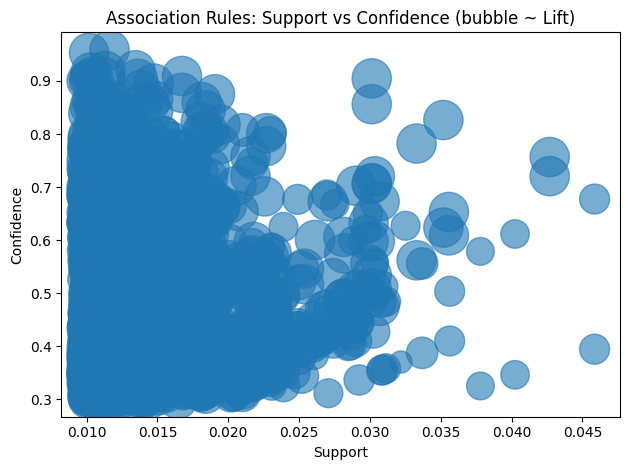

/Users/maanyachaturvedi/Downloads/market_basket_fp_growth/src/market_basket/viz.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


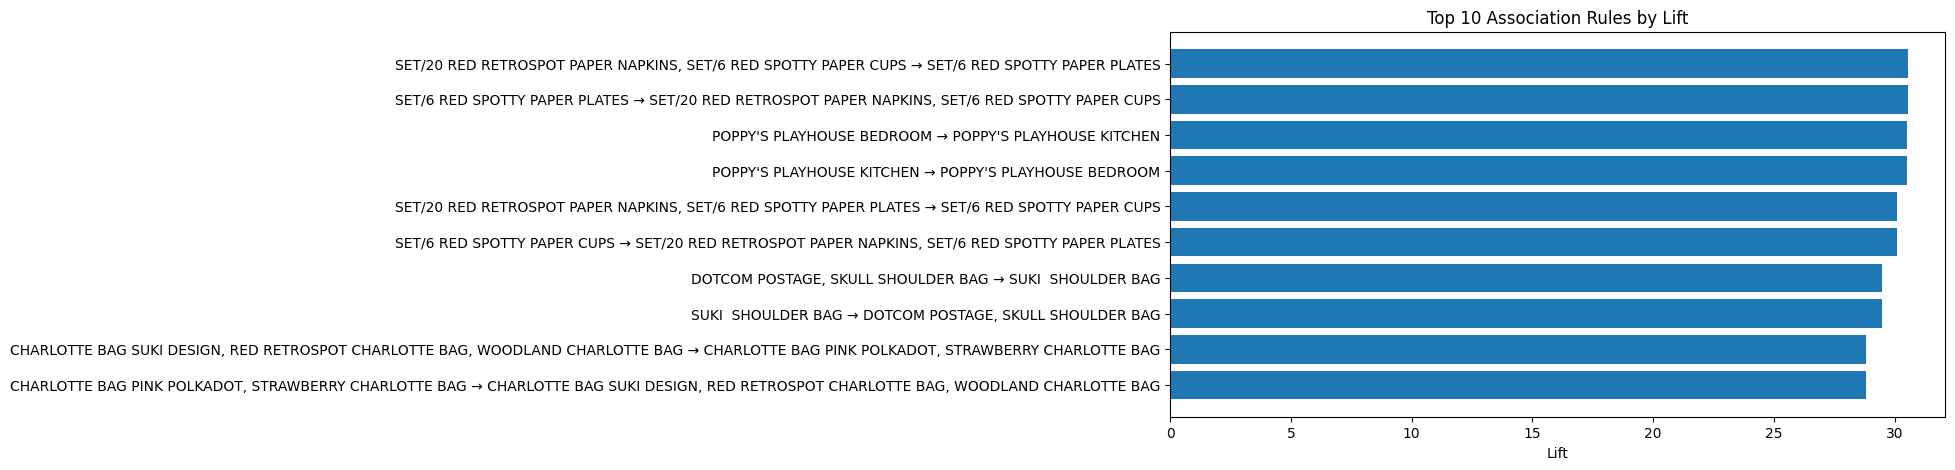

/Users/maanyachaturvedi/Downloads/market_basket_fp_growth/src/market_basket/viz.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


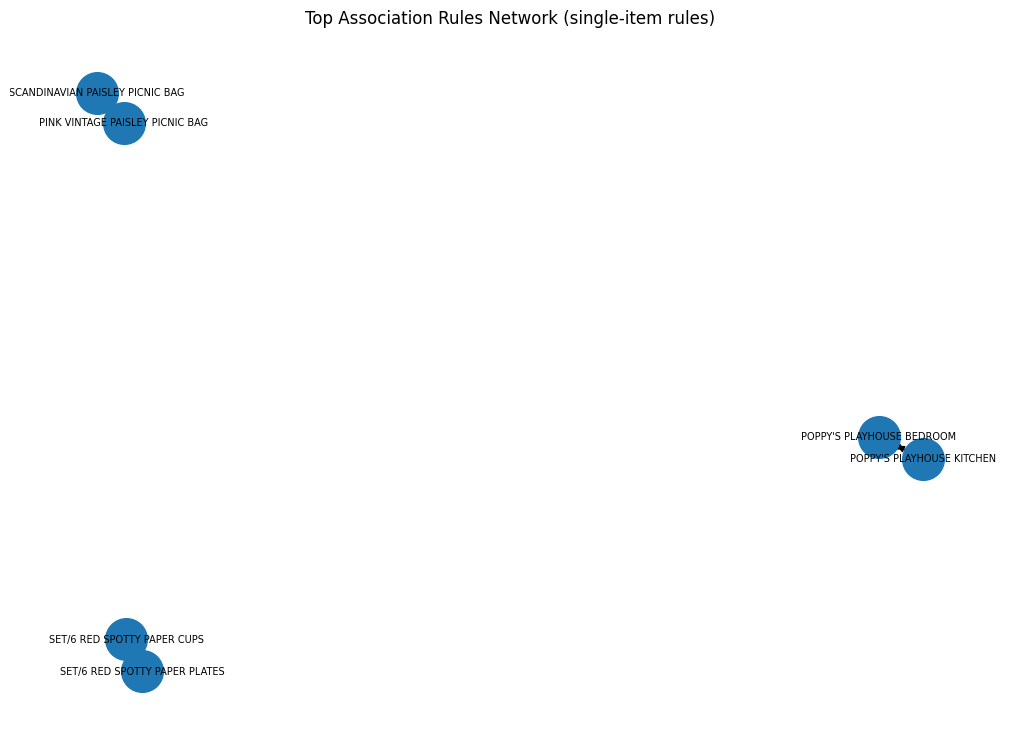

In [12]:
import matplotlib.pyplot as plt
fig_dir = project_root / "figures"
fig_dir.mkdir(exist_ok=True)

plot_support_confidence_bubble(rules, str(fig_dir / "support_confidence_bubble.png"))
plt.show()
plot_top_rules_by_lift(rules, mining_cfg, str(fig_dir / "top_rules_by_lift.png"))
plt.show()
plot_rules_network_single_item(rules, mining_cfg, str(fig_dir / "rules_network.png"))
plt.show()